In [14]:
from langgraph.graph import END, StateGraph
from core.models.agent_state import AgentState
from config.personality import AI_NAME
from langchain_openai import ChatOpenAI
from services.tools.llm_selector_tool import LLMSelectorTool
import os
from dotenv import load_dotenv


load_dotenv()


llm_orquester = LLMSelectorTool()

In [15]:
def select_llm(state: AgentState) -> AgentState: # type: ignore
    """Este nodo carga el asistente virtual"""
    llm_selected = state["llm_choice"]

    if llm_selected in ["openai", "mistralai"]:
        llms = llm_orquester._initialize_llms()
        state["llm_selected"] = llms.get(llm_selected)

        if not state["llm_selected"]:
            state["message_error"] = f"LLM '{llm_selected}' no disponible"
    else:
        state["llm_selected"] = None
        state["message_error"] = f"LLM '{llm_selected}' no reconocido"


    return state

In [16]:
def initialize_llm(state: AgentState) -> AgentState: # type: ignore
    user_message = state["user_input"]
    selected_llm = state["llm_selected"]

    if not selected_llm:
        state["response"] = "No se ha seleccionado un LLM válido"
        return state

    prompt = f"""

        Analiza de acuerdo al prompt proporcionado la
        solicitud del usuario

        Contenta de manera coherente, teniendo encuenta
        la siguiente personalidad: {AI_NAME}

        El usuario te ha preguntado: {user_message}
    """
    try:
        response = selected_llm(prompt) # type: ignore
        state["response"] = response # type: ignore
        return state
    except Exception as e:
        state["response"] = f"Error al procesar la solicitud: {str(e)}"

    return state

In [17]:
from langchain.tools import BaseTool
from langchain_openai import ChatOpenAI
from langchain_mistralai import ChatMistralAI
from dotenv import load_dotenv
from pydantic import PrivateAttr
from typing import Any, Dict
import os

load_dotenv()

class LLMSelectorTool(BaseTool):
    name: str = "llm_selector"
    description: str = "Selecciona y ejecuta el LLM"

    _llm_instances: Dict[str, Any] = PrivateAttr()

    def __init__(self):
        super().__init__()
        self._llm_instances = self._initialize_llms()

    def _initialize_llms(self):
        llms = {}

        if os.getenv("OPENAI_API_KEY"):
            llms["openai"] = ChatOpenAI(
                model="gpt-4o",
                api_key=os.getenv("OPENAI_API_KEY"),  # type: ignore
                temperature=0.7
            )

        if os.getenv("MISTRAL_API_KEY"):
            llms["mistralai"] = ChatMistralAI(
                model_name="open-mistral-nemo",
                api_key=os.getenv("MISTRAL_API_KEY"),  # type: ignore
                temperature=0.7
            )

        return llms

    def _run(self, llm_name: str) -> Any:
        if llm_name not in self._llm_instances:
            return f"Modelo '{llm_name}' no está disponible."

        llm = self._llm_instances[llm_name]
        response = llm("Hola, ¿puedes decirme tu nombre?")
        return response.content

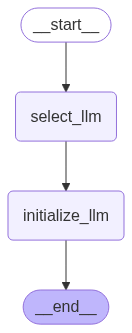

In [18]:
from langgraph.checkpoint.memory import InMemorySaver

graph = StateGraph(AgentState)

graph.add_node("select_llm", select_llm)
graph.add_node("initialize_llm", initialize_llm)

graph.set_entry_point("select_llm")

graph.add_edge("select_llm", "initialize_llm")
graph.add_edge("initialize_llm", END)

memory = InMemorySaver()

graph.compile(checkpointer=memory)